# (19) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 1
device = f'cuda:{device_idx}'

## vH16

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jac|lin')

cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 10

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 600
cfg_tr['batch_size'] = 500
cfg_tr['kl_beta'] = 10.0

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'enc_type': 'jac', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.01, 'seq_len': 10}

Trainer:
{'batch_size': 500, 'epochs': 600, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 'kl_const_portion': 
0.0, 'lr': 0.002, 'kl_beta': 10.0}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  132.1 K   |
|     ———     |    ———     |
|  layers.L_0 |  132.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-10_z-[512]_k-32_<jac|lin>
mc_b500-ep600-lr(0.002)_beta(10:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_30,17:15)

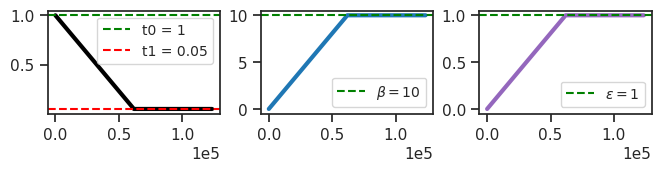

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

### Fit model

In [6]:
tr.cfg.kl_balancer

'equal'

In [7]:
tr.train(fit_name = f"dMSE+LogGain_bal-{tr.cfg.kl_balancer}_{tr.cfg.name()}")

epoch # 600, avg loss: 93.887172: 100%|████████████████████████████████████████████████████████| 600/600 [2:46:48<00:00, 16.68s/it]


In [9]:
print(tr.model.input_layer)

PoissonLayer(dim=512, input_dim=16, temp=0.05, n_exp=77, beta=10, eps=1)

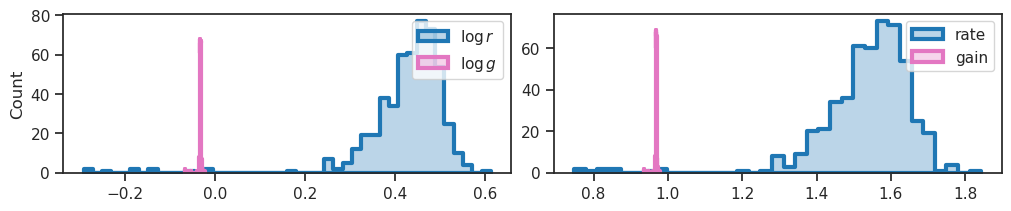

In [11]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
log_gain = tonp(tr.model.input_layer.log_gain).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)
sns.histplot(log_gain, color='C6', element='step', label=r'$\log g$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(np.exp(log_gain), color='C6', element='step', label='gain', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

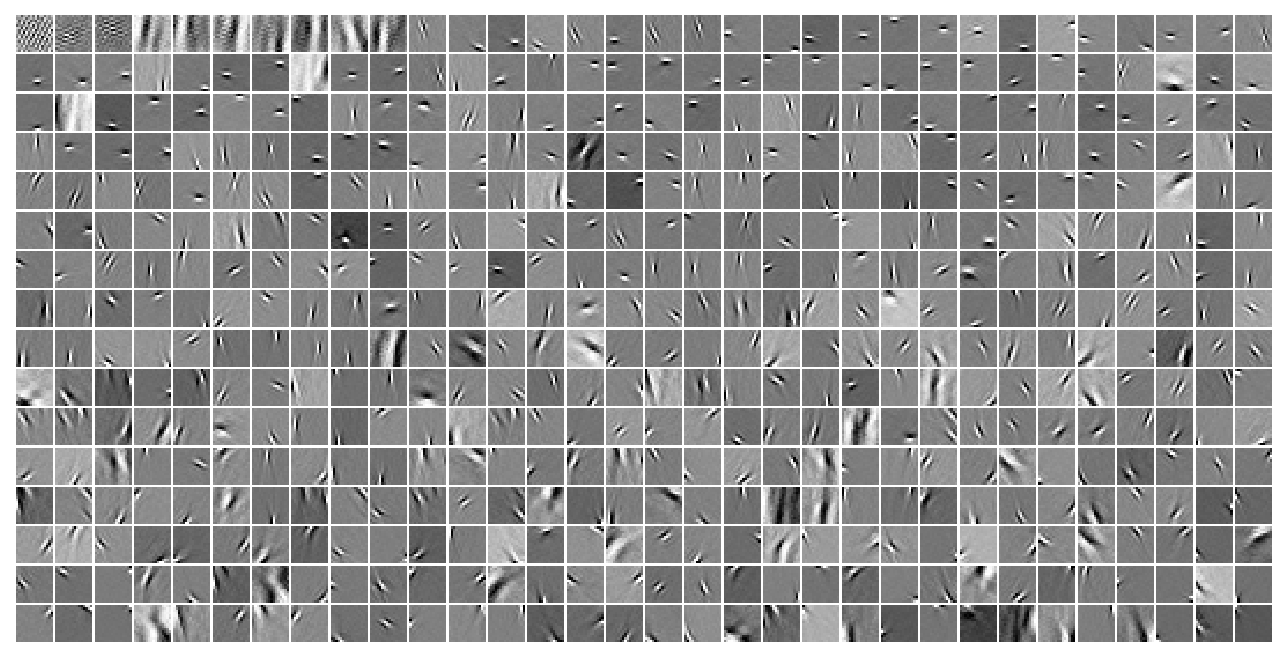

In [12]:
tr.model.show('dec', order=np.argsort(log_rate));

In [13]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{
    'kl': array([9.958574 , 8.965207 , 7.828064 , 6.688749 , 5.4533434, 4.34768  ,
       3.5306017, 2.9896846, 2.6480165, 2.4421434], dtype=float32),
    'recon': array([171.65099 , 142.27322 , 117.23298 ,  97.00103 ,  81.444664,
        70.05632 ,  61.962704,  56.06119 ,  51.830715,  48.60216 ],
      dtype=float32),
    'nelbo': array([181.61037 , 151.23872 , 125.0609  , 103.68985 ,  86.898125,
        74.40412 ,  65.49283 ,  59.050976,  54.478798,  51.044178],
      dtype=float32)
}

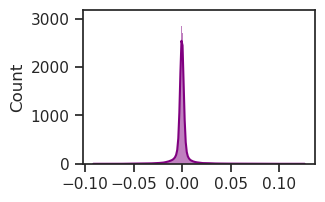

In [14]:
w = tonp(tr.model.input_layer.fc_dec.get_weight().data)
sns.histplot(w.ravel(), color='purple', kde=True);

In [15]:
results = tr.analysis(verbose=True)

100%|█████████████████████████████████| 52/52 [03:11<00:00,  3.69s/it]


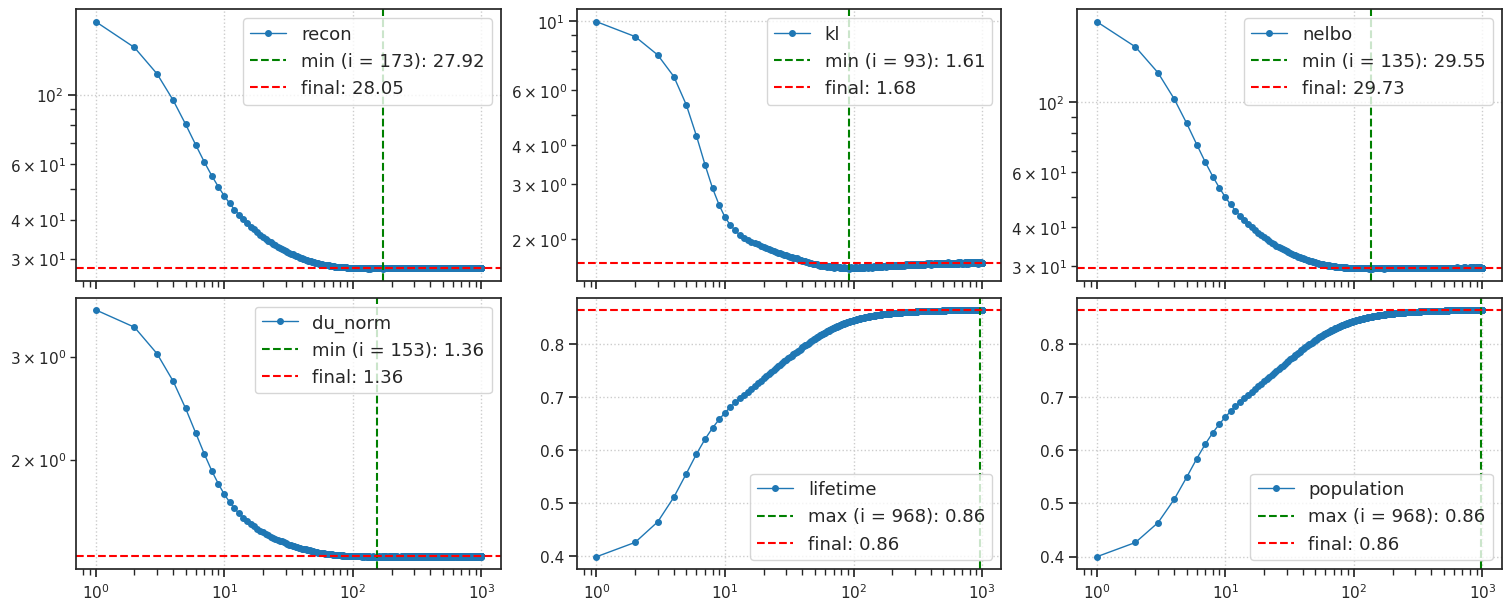

In [16]:
from figures.analysis import plot_convergence
plot_convergence(results)

## MNIST

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'lin|mlp+b')

cfg_vae['init_scale'] = 1e-2
cfg_vae['n_latents'] = [100]
cfg_vae['seq_len'] = 5

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 500
cfg_tr['batch_size'] = 200 
cfg_tr['kl_beta'] = 5.0
cfg_tr['kl_balancer'] = 'equal'

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_latents': [100], 'prior_clamp': -2, 'enc_type': 'lin', 'dec_type': 'mlp', 'enc_bias': 
False, 'dec_bias': True, 'init_dist': 't', 'init_scale': 0.01, 'seq_len': 5}

Trainer:
{'epochs': 500, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 'grad_clip': 1000,
'kl_const_portion': 0.01, 'lr': 0.002, 'kl_beta': 5.0, 'kl_balancer': 'equal'}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  559.7 K   |
|     ———     |    ———     |
|  layers.L_0 |  559.7 K   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_t-5_z-[100]_k-32_<lin|mlp+b>
mc_b200-ep500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_08_28,22:47)

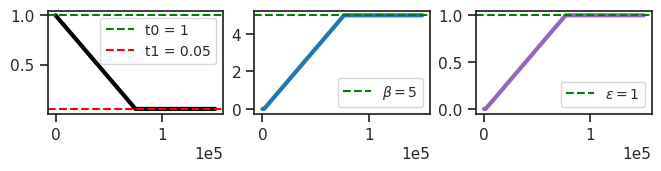

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
print_num_params(tr.model.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  559.7 K   |
|     ———      |    ———     |
|     dec      |  559.6 K   |
+--------------+------------+

### Fit model

In [7]:
comment = f"jacobian_bal-{tr.cfg.kl_balancer}"
fit_name = f"{comment}_{tr.cfg.name()}"

tr.train(fit_name=fit_name)

epoch # 500, avg loss: 26.507193: 100%|████████████████████████████████████████████████████████| 500/500 [2:42:46<00:00, 19.53s/it]


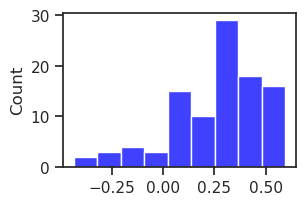

In [8]:
log_rate = tonp(tr.model.input_layer.log_rate.ravel())
sns.histplot(log_rate, color='b');

In [9]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{
    'kl': array([5.206186 , 4.614596 , 2.877102 , 1.5886844, 1.098612 ],
      dtype=float32),
    'recon': array([41.724323, 26.740248, 19.458012, 16.329227, 14.657322],
      dtype=float32),
    'nelbo': array([46.93046 , 31.354906, 22.335104, 17.917925, 15.75595 ],
      dtype=float32)
}

In [11]:
results = tr.analysis(verbose=True)

100%|█████████████████████████████████| 50/50 [02:26<00:00,  2.94s/it]


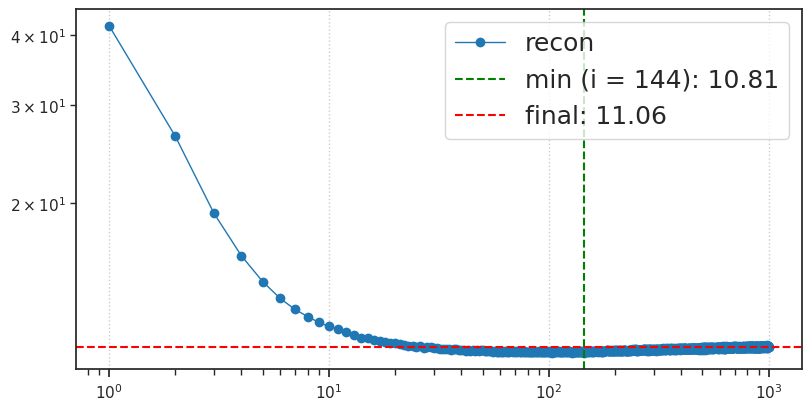

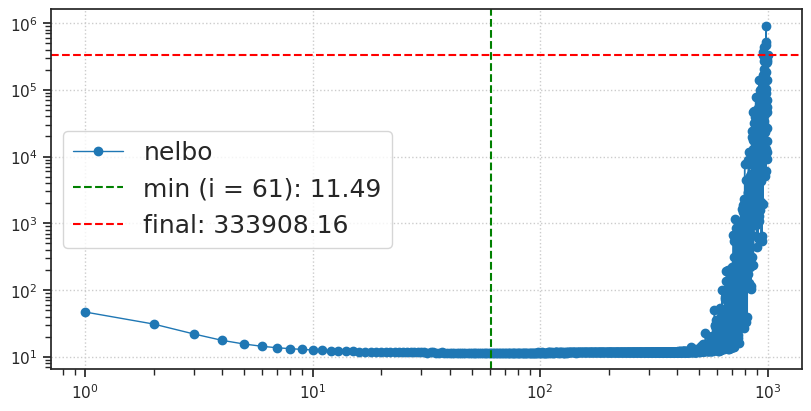

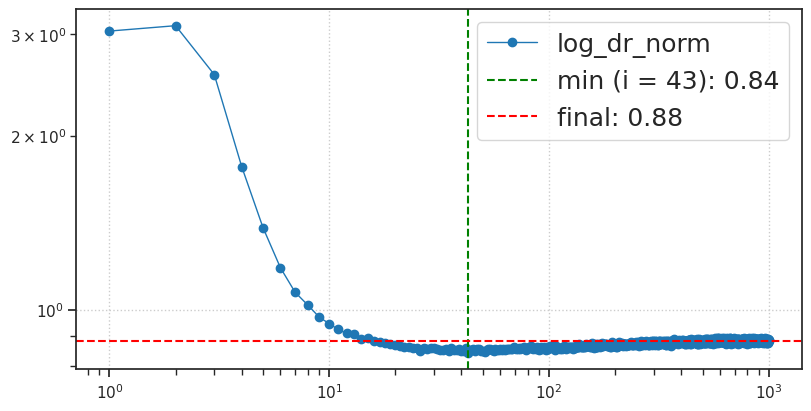

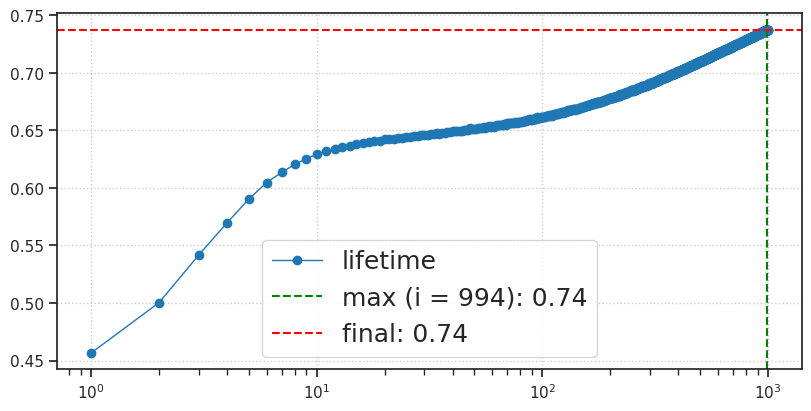

In [12]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['recon'])), results['recon'], lw=1, marker='o', label='recon')

min_i = np.argmin(results['recon'])
last = results['recon'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i + 1}): {results['recon'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()


fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['nelbo'])), results['nelbo'], lw=1, marker='o', label='nelbo')

min_i = np.argmin(results['nelbo'])
last = results['nelbo'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i + 1}): {results['nelbo'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()


fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['log_dr_norm'])), results['log_dr_norm'], lw=1, marker='o', label='log_dr_norm')

min_i = np.argmin(results['log_dr_norm'])
last = results['log_dr_norm'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i + 1}): {results['log_dr_norm'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()


fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['lifetime'])), results['lifetime'], lw=1, marker='o', label='lifetime')

max_i = np.argmax(results['lifetime'])
last = results['lifetime'][-1]
ax.axvline(max_i - 1, color='g', ls='--', label=f"max (i = {max_i - 1}): {results['lifetime'][max_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='linear')
ax.legend(fontsize=18)
ax.grid()
plt.show()

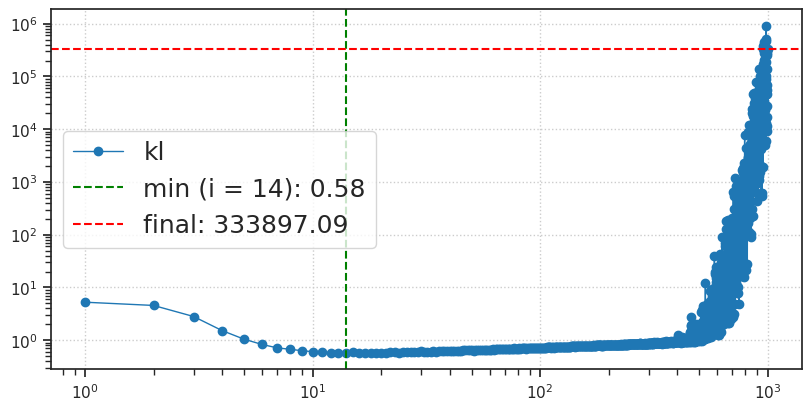

In [13]:
fig, ax = create_figure(1, 1, (8, 4))
ax.plot(range(1, 1 + len(results['kl'])), results['kl'], lw=1, marker='o', label='kl')

min_i = np.argmin(results['kl'])
last = results['kl'][-1]
ax.axvline(min_i + 1, color='g', ls='--', label=f"min (i = {min_i + 1}): {results['kl'][min_i]:0.2f}")
ax.axhline(last, color='r', ls='--', label=f"final: {last:0.2f}")

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=18)
ax.grid()
plt.show()